# Import packages

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm, tqdm_notebook, trange
from scipy.optimize import fmin
from pylab import rcParams
from IPython.display import clear_output
import copy
rcParams['figure.figsize'] = 8, 5

In [102]:
from sklearn.metrics import f1_score, roc_auc_score, log_loss, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from eli5.permutation_importance import get_score_importances as importances
import lightgbm as lgb

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from torch.autograd import Variable

# Additional functions

In [4]:
class TrainTestHelper(object):
    def __init__(self):
        self.ntrain = None

    def combine(self, train, test):
        self.ntrain = train.shape[0]
        if isinstance(train, np.ndarray):
            return np.row_stack((train, test))
        else:
            return train.append(test).reset_index(drop=True)

    def split(self, train_test):
        if self.ntrain is None:
            return None
        if isinstance(train_test, np.ndarray):
            train = train_test[:self.ntrain, :]
            test = train_test[self.ntrain:, :]
        else:
            train = train_test.iloc[:self.ntrain, :].copy().reset_index(drop=True)
            test = train_test.iloc[self.ntrain:, :].copy().reset_index(drop=True)
        return train, test

In [5]:
class LGBWrapper(object):
    def __init__(self, params=None):
        self.params = params

    def fit(self, X, y):
        _X = lgb.Dataset(X, label=y)
        self.model = lgb.train(self.params, _X)

    def predict(self, X):
        return self.model.predict(X)

In [6]:
def get_oof_pred(model, X, y, folds):   
    cvpred = np.zeros(X.shape[0])
    for tr, te in tqdm_notebook(folds.split(X, y)):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        cvpred[te] = model.predict(X_te)
    return cvpred

In [7]:
# just without tqdm
def get_oof_pred2(model, X, y, folds):   
    cvpred = np.zeros(X.shape[0])
    for tr, te in folds.split(X, y):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        cvpred[te] = model.predict(X_te)
    return cvpred

In [8]:
def get_oof(model, X, y, test, folds, metric, permute=False):
    
    def score(X, y):
        y_pred = model.predict(X)
        return metric(y, y_pred)
    
    cvpred = np.zeros(X.shape[0])
    pred = np.zeros(test.shape[0])
    global_imp = np.zeros(X.shape[1])
    for tr, te in tqdm_notebook(folds.split(X, y)):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        cvpred[te] = model.predict(X_te)
        pred += model.predict(test)
        if permute is True:
            base_score, local_imp = importances(score, X_te.values, y_te, n_iter=5, random_state=0)
            global_imp += np.mean(local_imp, axis=0)
    global_imp /= folds.get_n_splits() * (-1)
    pred /= folds.get_n_splits()
    return cvpred, pred, global_imp

#compute permutation importance and run 'BACKWARD'
class FeatureSelector(object):
    def __init__(self, model, folds, metric):
        self.model = model
        self.folds = folds
        self.metric = metric
    
    def fit(self, X, y, test):
        cvpred, pred, importance = get_oof(self.model, X, y, test, self.folds, self.metric, permute=True)
        base_score = self.metric(y, cvpred)
        best_score = base_score
        self.initial_importance = sorted(list(zip(importance, X.columns)), key=lambda x: x[0])
        with open('WNS_selector_importance_raw', 'wb') as fp:
            pickle.dump(dict(self.initial_importance), fp)
        to_drop = []
        print('Base score is:', base_score, '\n')
        for f in tqdm_notebook(self.initial_importance):
            to_drop.append(f[1])
            _X = X.drop(to_drop, axis=1)
            _test = test.drop(to_drop, axis=1)
            cvpred, pred, imp = get_oof(self.model, _X, y, _test, self.folds, self.metric)
            if self.metric(y, cvpred) > best_score:
                to_drop.pop()
            else:
                print('Feature ' + str(f[1]) + ' has been dropped >>')
                print('Score: ' + str(best_score) + ' -> ' + str(self.metric(y, cvpred)))
                best_score = self.metric(y, cvpred)
                print()        
        print('Final score: ', best_score)
        self.weak_features = to_drop
        self.strong_features = list(set(X.columns) - set(to_drop))
        self.oof_train = cvpred
        self.oof_test = pred
        self.final_importance = imp
        return self

In [9]:
def get_oof2(model, X, y, test, folds, metric, permute=False):
    
    def score(X, y):
        y_pred = model.predict(X)
        
        def minus_f_score(cutoff):
            if (cutoff < 0) or (cutoff > 1):
                return np.inf
            else:
                return - 1* f1_score(y, 1 * (y_pred > cutoff))
            
        cutoff_null = [0]
        cut_f_min = fmin(minus_f_score, cutoff_null, disp=False)
        cut = cut_f_min[0]
            
        return f1_score(y, 1 * (y_pred > cut))
    
    cvpred = np.zeros(X.shape[0])
    pred = np.zeros(test.shape[0])
    global_imp = np.zeros(X.shape[1])
    for tr, te in folds.split(X, y):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        cvpred[te] = model.predict(X_te)
        pred += model.predict(test)
        if permute is True:
            base_score, local_imp = importances(score, X_te.values, y_te, n_iter=5, random_state=0)
            global_imp += np.mean(local_imp, axis=0)
    global_imp /= folds.get_n_splits()
    pred /= folds.get_n_splits()
    return cvpred, pred, global_imp
# Same, but score is optimal f1-score for each prediction
class FeatureSelector2(object):
    def __init__(self, model, folds, metric):
        self.model = model
        self.folds = folds
        self.metric = metric
        
    
    def fit(self, X, y, test):
        def score2(y, y_pred):
        
            def minus_f_score(cutoff):
                if (cutoff < 0) or (cutoff > 1):
                    return np.inf
                else:
                    return - 1* f1_score(y, 1 * (y_pred > cutoff))

            cutoff_null = [0]
            cut_f_min = fmin(minus_f_score, cutoff_null, disp=False)
            cut = cut_f_min[0]

            return f1_score(y, 1 * (y_pred > cut))
            
        cvpred, pred, importance = get_oof2(self.model, X, y, test, self.folds, self.metric, permute=True)
        base_score = score2(y, cvpred)
        best_score = base_score
        self.initial_importance = sorted(list(zip(importance, X.columns)), key=lambda x: x[0])
        to_drop = []
        print('Base score is:', base_score, '\n')
        for f in tqdm_notebook(self.initial_importance):
            to_drop.append(f[1])
            _X = X.drop(to_drop, axis=1)
            _test = test.drop(to_drop, axis=1)
            cvpred, pred, imp = get_oof2(self.model, _X, y, _test, self.folds, self.metric)
            if score2(y, cvpred) <= best_score:
                to_drop.pop()
            else:
                print('Feature ' + str(f[1]) + ' has been dropped >>')
                print('Score: ' + str(best_score) + ' -> ' + str(score2(y, cvpred)))
                best_score = score2(y, cvpred)
                print()        
        print('Final score: ', best_score)
        self.weak_features = to_drop
        self.strong_features = list(set(X.columns) - set(to_drop))
        self.oof_train = cvpred
        self.oof_test = pred
        self.final_importance = imp
        return self

In [10]:
def plot_history_a( M_train_history):
    plt.style.use('ggplot')
    plt.figure(figsize=[6,6])
    
    plt.title('MSE Loss')
    plt.plot(M_train_history, label='MSE', zorder=1, c='lightseagreen')
    plt.xlabel('Iteration')
    
    plt.legend   
    plt.show()

In [11]:
def iterate_minibatches_a(inputs,  batchsize, shuffle=False):             
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

# Data downloading

In [12]:
train = pd.read_csv('train_LZdllcl.xls')
test = pd.read_csv('test_2umaH9m.xls')
sub = pd.read_csv('sample_submission_M0L0uXE.xls')
del train['employee_id'], test['employee_id']

In [13]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (54808, 13)
Test shape: (23490, 12)


In [14]:
y = train['is_promoted']
del train['is_promoted']

In [10]:
train_no_feat = pd.read_csv('train_LZdllcl.xls')
test_no_feat = pd.read_csv('test_2umaH9m.xls')
del train_no_feat['is_promoted']
del train_no_feat['employee_id']
del test_no_feat['employee_id']

helper = TrainTestHelper()
data_no_feat = helper.combine(train_no_feat, test_no_feat)

to_cat = ['department',
          'region',
          'gender',
          'recruitment_channel']
for c in to_cat:
    data_no_feat[c] = pd.factorize(data_no_feat[c])[0]
    
ed_dict = {'Below Secondary': 0, 'Bachelor\'s': 1, 'Master\'s & above': 2}
data_no_feat['education'] = data_no_feat['education'].map(ed_dict)
train_no_feat, test_no_feat = helper.split(data_no_feat)

# Feature Generation

In [25]:
helper = TrainTestHelper()
data = helper.combine(train, test)

to_cat = ['department',
          'region',
          'gender',
          'recruitment_channel']
for c in to_cat:
    data[c] = pd.factorize(data[c])[0]
    
ed_dict = {'Below Secondary': 0, 'Bachelor\'s': 1, 'Master\'s & above': 2}
data['education'] = data['education'].map(ed_dict)
data = data.fillna(-1)

In [26]:
cont = ['avg_training_score', 'age' , 'education', 'length_of_service', 'previous_year_rating', 'no_of_trainings']
cat = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings',
       'KPIs_met >80%', 'awards_won?']
binary = ['gender', 'KPIs_met >80%', 'awards_won?']

## KNN features

### KNN for continuous features:

In [27]:
data_knn = copy.deepcopy(data)
for feat in tqdm_notebook(cont):
    X_knn = data_knn.drop(feat, axis=1)
    y_knn = data_knn[feat]
    for k in tqdm_notebook([5, 10, 50, 200, 1000]):
        knn = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
        knn.fit(X_knn, y_knn)
        pred_knn = knn.predict(X_knn)
        data['dist_'+feat+'_from_'+str(k)+'_nearest_neighbors'] = y_knn-pred_knn
        data[feat+'_divided_by_'+str(k)+'_nearest_neighbors'] = y_knn/pred_knn
        data[feat+'_'+str(k)+'_nearest_neighbors'] = pred_knn
    

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

### KNN for categorical features:

In [28]:
for feat in tqdm_notebook(cat):
    X_knn = data_knn.drop(feat, axis=1)
    y_knn = data_knn[feat].factorize()[0]
    for k in tqdm_notebook([5, 10, 50, 200, 1000]):
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_knn, y_knn)
        pred_knn = knn.predict(X_knn)
        pr = knn.predict_proba(X_knn)
        prob_of_curr_class = np.array([pr[n, j] for n , j in enumerate(y_knn)])
        data['Is_same_'+feat+'_from_'+str(k)+'_nearest_neighbors'] = (y_knn == pred_knn)
        data['most_likelihood_class_'+feat+'_from_'+str(k)+'_nearest_neighbors'] = pred_knn
        data['prob_of_most_likelihood_class_'+feat+'_from_'+str(k)+'_nearest_neighbors'] = pr.max(axis=1)
        data['prob_of_'+feat+'_'+str(k)+'_nearest_neighbors'] = prob_of_curr_class
        data['dist_to_most_likelihood_class_'+feat+'_'+str(k)+'_nearest_neighbors'] = pr.max(axis=1) -\
        prob_of_curr_class
        try:
            data['dist_from_least_likelihood_nonzero_class_'+feat+'_'+str(k)+'_nearest_neighbors'] = prob_of_curr_class -\
            np.array([i[i>0].min() for i in pr])
        except:
            pass

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [30]:
data_knn_feat = data[data.columns[12:]]

In [31]:
data_knn_feat.to_csv('data_knn_feat.csv', index=False)

In [32]:
helper = TrainTestHelper()
data = helper.combine(train, test)

to_cat = ['department',
          'region',
          'gender',
          'recruitment_channel']
for c in to_cat:
    data[c] = pd.factorize(data[c])[0]
    
ed_dict = {'Below Secondary': 0, 'Bachelor\'s': 1, 'Master\'s & above': 2}
data['education'] = data['education'].map(ed_dict)

In [33]:
data = pd.concat([data, data_knn_feat], axis=1)

## Intersect (1st and 2nd order) between binary and categorical features:

In [36]:
for bin_i in tqdm_notebook(binary):
    for cat_name in cat:
        if cat_name != bin_i:
            data[cat_name+'_intersect_'+bin_i] = data[cat_name]*data[bin_i]
for_dr = []            
for bin_i in tqdm_notebook(binary):
    for_dr.append(bin_i)
    for bin_j in list(set(binary) - set(for_dr)):
        for cat_name in cat:
            if bin_i != bin_j:
                if cat_name != bin_i:
                    data[cat_name+'_intersect_'+bin_i+'_'+bin_j] = data[cat_name]*data[bin_i]*data[bin_j]
                    
for cat_name in tqdm_notebook(cat):
        if cat_name not in binary:
            data[cat_name+'_intersect_all_binary'] = data[cat_name]*data['gender']*data['KPIs_met >80%']*data['awards_won?']

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [38]:
cat2 = cat + list(data.columns[342:])

## Simple interaction among continuous features:

In [39]:
for i in cont:
    for j in cont:
        if i != j:
            data[i+'_multiplied_by_'+j] = data[i]*data[j]
            try:
                data[i+'_divided_by_'+j] = data[i]/data[j]
            except:
                pass

## Some monotonical transformations of continuous features:

In [40]:
for columns in cont:
    data['log_'+columns] = np.log1p(data[columns])
    data['exp_'+columns] = np.expm1(data[columns])
    data['power_2_'+columns] = data[columns] ** 2
    data['power_075_'+columns] = data[columns] ** 0.75
    data['power_05_'+columns] = data[columns] ** 0.5
    data['power_025_'+columns] = data[columns] ** 0.25
    data['power_01_'+columns] = data[columns] ** 0.1    

## Aggregates and statistics of continuous features for given level of categorical feature:

In [41]:
for cont_name in tqdm_notebook(cont):
    for cat_name in tqdm_notebook(cat2):
        try:
            data[cat_name+'_mean_'+cont_name] = data[cat_name].map(dict(data.groupby(cat_name).mean()[cont_name]))
            data[cat_name+'_max_'+cont_name] = data[cat_name].map(dict(data.groupby(cat_name).max()[cont_name]))
            data[cat_name+'_min_'+cont_name] = data[cat_name].map(dict(data.groupby(cat_name).min()[cont_name]))
            data[cat_name+'_sum_'+cont_name] = data[cat_name].map(dict(data.groupby(cat_name).sum()[cont_name]))
            data[cat_name+'_count_'+cont_name] = data[cat_name].map(dict(data.groupby(cat_name).count()[cont_name]))

            data[cat_name+'_divided_by_max_'+cont_name] = data[cont_name]/data[cat_name+'_max_'+cont_name]
            data[cat_name+'_divided_by_mean_'+cont_name] = data[cont_name]/data[cat_name+'_mean_'+cont_name]
            data[cat_name+'_divided_by_sum_'+cont_name] = data[cont_name]/data[cat_name+'_sum_'+cont_name]
            data[cat_name+'_divided_by_count_'+cont_name] = data[cont_name]/data[cat_name+'_count_'+cont_name]

            data[cat_name+'_normed_by_min_max_'+cont_name] = (data[cont_name] - data[cat_name+'_min_'+cont_name])/ \
            (data[cat_name+'_max_'+cont_name] - data[cat_name+'_min_'+cont_name])

            data[cat_name+'_dist_from_min_'+cont_name] = (data[cont_name] - data[cat_name+'_min_'+cont_name])
            data[cat_name+'_dist_to_max_'+cont_name] = (data[cat_name+'_max_'+cont_name] - data[cont_name])
            data[cat_name+'_dist_from_mean_'+cont_name] = (data[cont_name] - data[cat_name+'_mean_'+cont_name])
        except:
            pass
        

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [42]:
data.to_csv('data_feat.csv', index=False)

## Simple reconstruction error:

In [53]:
scaler = MinMaxScaler()
scaler.fit(data_knn)
X_train = scaler.transform(data_knn)

In [80]:
class Autoencoder(nn.Module):
    def __init__(self):
        
        super(Autoencoder, self).__init__()    
        self.fc1 = nn.Linear(int(X_train.shape[1]), int(X_train.shape[1]/2))
        self.fc2 = nn.Linear(int(X_train.shape[1]/2), int(X_train.shape[1]/2))
        self.fc3 = nn.Linear(int(X_train.shape[1]/2), int(X_train.shape[1]))       
        
    def forward(self, x1):
        inputs = x1 
        x = F.leaky_relu(self.fc1(inputs))
        x = F.leaky_relu(self.fc2(x))
        output = F.sigmoid(self.fc3(x))
        return output
        
    def get_error_mse(self, x):
    
        X_mb = Variable(torch.from_numpy(x)).type(torch.FloatTensor).cuda()        
        auto = self.forward(X_mb)
        output = torch.mean((X_mb - auto)**2, dim=1)
        
        return output.data.cpu().numpy()
    
    def get_error_mae(self, x):
    
        X_mb = Variable(torch.from_numpy(x)).type(torch.FloatTensor).cuda()        
        auto = self.forward(X_mb)
        output = torch.mean(torch.abs(X_mb - auto), dim=1)
        
        return output.data.cpu().numpy()

In [81]:
def train_a(model, opt, batchsize=200):
    MSE_log =  []
    for x_batch in iterate_minibatches_a(X_train, batchsize=batchsize, shuffle=True):
        X_mb = Variable(torch.from_numpy(x_batch)).type(torch.FloatTensor).cuda()
        A_solver = opt            
        A_solver.zero_grad()
        output = model(X_mb)
        MSE_train_loss = torch.mean(( X_mb - output)**2)
        MSE_train_loss.backward()
        
        A_solver.step()
        MSE_loss = MSE_train_loss.cpu().data.numpy()
        MSE_log.append(MSE_loss)
        
    return MSE_log

Epoch: 1, MSE loss: 0.018566854298114777


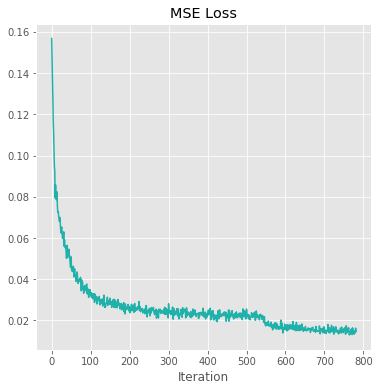

In [87]:
torch.cuda.manual_seed(60)
torch.manual_seed(60)

MSE_loss_log = []

batchsize = 200
lr = 0.02


Autoencoder_model = Autoencoder().cuda()

opt = torch.optim.Adam(Autoencoder_model.parameters(), lr=lr)

for epoch in range(2):
    steps = X_train.shape[0]/batchsize

    MSE_loss = train_a(Autoencoder_model, opt, batchsize=batchsize)

    MSE_loss_log.extend(MSE_loss) 
    clear_output()
    print('Epoch: {e}, MSE loss: {M1}'.format(e=epoch, M1=np.mean(MSE_loss)))
    
    plot_history_a( MSE_loss_log)

In [84]:
data['reconstruction_error_mse'] = Autoencoder_model.eval().get_error_mse(X_train)
data['reconstruction_error_mae'] = Autoencoder_model.eval().get_error_mae(X_train)

In [85]:
data.to_csv('data_feat_with_re.csv', index=False)

In [11]:
data = pd.read_csv('data_feat_with_re.csv')

In [17]:
train, test = helper.split(data)

In [90]:
del X_train
del data_knn
del data_knn_feat
del X_knn
del y_knn
del data

In [13]:
train.shape

(54808, 4757)

# Feature selection

In [141]:
folds = KFold(n_splits=3, shuffle=True, random_state=0)

## Raw feature importances:

In [23]:
imp_auc = []
for col in tqdm_notebook(train.columns):
    imp_auc.append([col , 2*np.abs(roc_auc_score(y, train[col].replace([np.inf, -np.inf], [np.NaN, np.NaN]).fillna(-1)))-1])

A Jupyter Widget

In [28]:
df = pd.DataFrame(imp_auc, columns=['Feature', 'Gini'])

In [119]:
df[df.Gini > 0.35 ].sort_values('Gini').iloc[-10:]

,Feature,Gini
733,gender_intersect_KPIs_met >80%_divided_by_coun...,0.468511
940,KPIs_met >80%_intersect_gender_KPIs_met >80%_d...,0.468511
707,region_intersect_KPIs_met >80%_divided_by_coun...,0.474005
706,region_intersect_KPIs_met >80%_divided_by_sum_...,0.474302
720,education_intersect_KPIs_met >80%_divided_by_c...,0.507860
719,education_intersect_KPIs_met >80%_divided_by_s...,0.507860
759,no_of_trainings_intersect_KPIs_met >80%_divide...,0.528221
758,no_of_trainings_intersect_KPIs_met >80%_divide...,0.528329
576,KPIs_met >80%_divided_by_sum_avg_training_score,0.544554
577,KPIs_met >80%_divided_by_count_avg_training_score,0.545403


In [153]:
feat_gini = df[df.Gini > 0.4 ].sort_values('Gini').Feature

In [55]:
from lightgbm.sklearn import LGBMClassifier

In [59]:
cv_lbg = lgb.cv(nfold=2, shuffle=True,
                metrics='log_loss', params=params2, seed=0, train_set=lgb.Dataset(train, label=y))

In [64]:
m = lgb.LGBMClassifier()

In [65]:
m.fit(train, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [67]:
imp_lgb = m.feature_importances_

In [93]:
df2 = pd.DataFrame(np.array([train.columns, imp_lgb]).T, columns=['Feature', 'imp']).sort_values('imp')

## Selectors:

In [143]:
imp_dict = dict(np.array([imp_lgb + np.random.uniform(0,0.1, imp_lgb.shape), train.columns]).T)
ar_imp = np.array(list(imp_dict.keys()))

In [147]:
# 'FORWARD'
feat = []
for i in tqdm(list(reversed([imp_dict.get(g) for g in np.sort(ar_imp)]))):
    feat.append(i)
    if len(feat)==5:
        model = LGBWrapper(params2)
        oof_pred = get_oof_pred2(model, train[feat], y, folds)
        base_score = log_loss(y, oof_pred)
        print('Base score: {bs}'.format(bs = base_score))
    if len(feat)>5:
        model = LGBWrapper(params2)
        oof_pred = get_oof_pred2(model, train[feat], y, folds)
        if log_loss(y, oof_pred) >= base_score:
            feat.pop()
        else:
            base_score = log_loss(y, oof_pred)
            print('feat {i} was added. Base score: {bs}'.format(i=i, bs = base_score))


  0%|          | 0/4757 [00:00<?, ?it/s]

Base score: 0.17147941675925427



  0%|          | 5/4757 [00:02<32:41,  2.42it/s]

feat reconstruction_error_mse was added. Base score: 0.16983953986001696



  0%|          | 6/4757 [00:04<55:22,  1.43it/s]
Exception in thread Thread-54:
Traceback (most recent call last):
  File "C:\Users\Simakov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Simakov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Simakov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



feat region_mean_previous_year_rating was added. Base score: 0.16777816629767137


  0%|          | 9/4757 [00:11<1:39:03,  1.25s/it]

feat avg_training_score_multiplied_by_previous_year_rating was added. Base score: 0.16394556153417378


  0%|          | 12/4757 [00:19<2:05:55,  1.59s/it]

feat avg_training_score_50_nearest_neighbors was added. Base score: 0.16372975261980957


  0%|          | 14/4757 [00:24<2:17:59,  1.75s/it]

feat previous_year_rating_1000_nearest_neighbors was added. Base score: 0.16337398884069185


  0%|          | 22/4757 [00:48<2:53:22,  2.20s/it]

feat dist_from_least_likelihood_nonzero_class_education_50_nearest_neighbors was added. Base score: 0.16331212043430388


  1%|          | 25/4757 [00:57<3:00:56,  2.29s/it]

feat no_of_trainings_intersect_KPIs_met >80%_divided_by_count_previous_year_rating was added. Base score: 0.16324983606508922


  1%|          | 26/4757 [01:00<3:03:13,  2.32s/it]

feat prob_of_KPIs_met >80%_1000_nearest_neighbors was added. Base score: 0.16300410168492674


  1%|          | 34/4757 [01:27<3:23:13,  2.58s/it]

feat length_of_service_divided_by_10_nearest_neighbors was added. Base score: 0.16299938645307938


  1%|          | 48/4757 [02:18<3:46:57,  2.89s/it]

feat region_mean_age was added. Base score: 0.16290384822618736


  1%|          | 51/4757 [02:30<3:50:51,  2.94s/it]

feat department_intersect_KPIs_met >80%_divided_by_sum_previous_year_rating was added. Base score: 0.16272639210852405


  1%|          | 53/4757 [02:37<3:53:30,  2.98s/it]

feat age_divided_by_5_nearest_neighbors was added. Base score: 0.16267482634147915


  1%|          | 54/4757 [02:41<3:54:48,  3.00s/it]

feat prob_of_most_likelihood_class_recruitment_channel_from_50_nearest_neighbors was added. Base score: 0.16232515498231465


  2%|▏         | 114/4757 [06:53<4:40:54,  3.63s/it]

feat prob_of_awards_won?_200_nearest_neighbors was added. Base score: 0.16205090249129173


  2%|▏         | 115/4757 [06:57<4:41:08,  3.63s/it]

feat department_divided_by_max_no_of_trainings was added. Base score: 0.162019554791642


  3%|▎         | 119/4757 [07:15<4:42:49,  3.66s/it]

feat dist_from_least_likelihood_nonzero_class_awards_won?_50_nearest_neighbors was added. Base score: 0.16187452772640312


  3%|▎         | 121/4757 [07:24<4:43:38,  3.67s/it]

feat prob_of_most_likelihood_class_gender_from_10_nearest_neighbors was added. Base score: 0.16186105655919839


  3%|▎         | 124/4757 [07:37<4:45:00,  3.69s/it]

feat education_divided_by_5_nearest_neighbors was added. Base score: 0.1616007244095151


  3%|▎         | 128/4757 [07:56<4:47:07,  3.72s/it]

feat recruitment_channel_intersect_gender_KPIs_met >80%_divided_by_mean_previous_year_rating was added. Base score: 0.16145093533609864


  3%|▎         | 129/4757 [08:01<4:47:36,  3.73s/it]

feat no_of_trainings_intersect_gender_divided_by_sum_age was added. Base score: 0.16129783409065765


  3%|▎         | 138/4757 [08:45<4:53:13,  3.81s/it]

feat dist_from_least_likelihood_nonzero_class_awards_won?_200_nearest_neighbors was added. Base score: 0.16121040165459838


  3%|▎         | 150/4757 [09:48<5:01:01,  3.92s/it]

feat previous_year_rating_divided_by_no_of_trainings was added. Base score: 0.16118146587996257


  8%|▊         | 390/4757 [30:55<5:46:22,  4.76s/it]

feat most_likelihood_class_no_of_trainings_from_5_nearest_neighbors was added. Base score: 0.16111096951505416


 17%|█▋        | 790/4757 [1:06:12<5:32:27,  5.03s/it]

feat awards_won?_intersect_KPIs_met >80%_dist_to_max_previous_year_rating was added. Base score: 0.16110925307823945


 17%|█▋        | 811/4757 [1:08:04<5:31:15,  5.04s/it]

feat no_of_trainings_sum_length_of_service was added. Base score: 0.16110739052253567


 20%|█▉        | 931/4757 [1:19:00<5:24:43,  5.09s/it]

feat no_of_trainings_intersect_awards_won? was added. Base score: 0.16110738700659838


 23%|██▎       | 1076/4757 [1:32:16<5:15:41,  5.15s/it]

feat department_intersect_KPIs_met >80%_min_age was added. Base score: 0.16110728255413545


 34%|███▍      | 1622/4757 [2:23:18<4:36:58,  5.30s/it]

feat region_intersect_all_binary_min_length_of_service was added. Base score: 0.16109529542439033


 39%|███▊      | 1838/4757 [2:43:52<4:20:15,  5.35s/it]

feat dist_to_most_likelihood_class_awards_won?_200_nearest_neighbors was added. Base score: 0.16109356950999537


 48%|████▊     | 2267/4757 [3:25:03<3:45:14,  5.43s/it]

feat no_of_trainings_intersect_gender_min_no_of_trainings was added. Base score: 0.16107215687197324


 52%|█████▏    | 2465/4757 [3:44:20<3:28:35,  5.46s/it]

feat recruitment_channel_intersect_awards_won?_max_avg_training_score was added. Base score: 0.16104430259607022


 74%|███████▍  | 3532/4757 [5:30:03<1:54:28,  5.61s/it]

feat no_of_trainings_intersect_gender_KPIs_met >80%_min_no_of_trainings was added. Base score: 0.16095980600371632


 99%|█████████▉| 4706/4757 [7:29:42<04:52,  5.73s/it]  

feat region_intersect_awards_won?_min_previous_year_rating was added. Base score: 0.16093125608978612


100%|██████████| 4757/4757 [7:34:59<00:00,  5.74s/it]


In [148]:
with open('WNS_selector2_strong_feat', 'wb') as fp:
    pickle.dump(feat, fp)

In [149]:
with open('WNS_selector2_strong_feat', 'rb') as fp:
    selector2_strong_feat = pickle.load(fp)

In [157]:
data[selector2_strong_feat+['reconstruction_error_mse', 'reconstruction_error_mae']+list(feat_gini)] 

(78298, 66)

### add features

In [162]:
train_no_feat = pd.read_csv('train_LZdllcl.xls')
test_no_feat = pd.read_csv('test_2umaH9m.xls')
del train_no_feat['is_promoted']
del train_no_feat['employee_id']
del test_no_feat['employee_id']

helper = TrainTestHelper()
data_no_feat = helper.combine(train_no_feat, test_no_feat)

In [163]:
data_no_feat['department|training'] = data_no_feat['department'] + \
np.digitize(data_no_feat['avg_training_score'], [c * 10 for c in range(3, 11)]).astype(str)
data_no_feat['kpi|training'] = data_no_feat['KPIs_met >80%'].astype(str) + \
np.digitize(data_no_feat['avg_training_score'], [c * 10 for c in range(3, 11)]).astype(str)
data_no_feat['department|kpi'] = data_no_feat['department'] + data_no_feat['KPIs_met >80%'].astype(str)
data_no_feat['kpi*rating'] = data_no_feat['KPIs_met >80%'] * data_no_feat['previous_year_rating']

data_no_feat['mean_training_by_department'] = \
data_no_feat['department'].map(data_no_feat.groupby('department')['avg_training_score'].mean())
data_no_feat['department_training_mean_ratio'] = data_no_feat['avg_training_score'] /\
data_no_feat['mean_training_by_department']

data_no_feat['mean_rating_by_department'] =\
data_no_feat['department'].map(data_no_feat.groupby('department')['previous_year_rating'].mean())
data_no_feat['department_rating_mean_ratio'] = data_no_feat['previous_year_rating'] / \
data_no_feat['mean_rating_by_department']

data_no_feat['mean_kpi_by_department'] = \
data_no_feat['department'].map(data_no_feat.groupby('department')['KPIs_met >80%'].mean())

In [164]:
to_cat = ['department',
          'region',
          'gender',
          'recruitment_channel',
          'department|training',
          'department|kpi',
          'kpi|training']
for c in to_cat:
    data_no_feat[c] = pd.factorize(data_no_feat[c])[0]

In [165]:
ed_dict = {'Below Secondary': 0, 'Bachelor\'s': 1, 'Master\'s & above': 2}
data_no_feat['education'] = data_no_feat['education'].map(ed_dict)

In [168]:
data_feat = pd.concat([data_no_feat,
                       data[selector2_strong_feat+['reconstruction_error_mse',
                                                   'reconstruction_error_mae']+list(feat_gini)]],
                      axis=1)

In [171]:
train, test = helper.split(data_feat)

## Second selector:

In [245]:
params = {'app': 'binary',
          'metric': 'binary_logloss',
          'n_jobs': -1}
model = LGBWrapper(params)

selector2 = FeatureSelector2(model=model, folds=folds, metric=f1_score)
selector2.fit(train, y, train)

Base score is: 0.522699717095514 



A Jupyter Widget

Exception in thread Thread-93:
Traceback (most recent call last):
  File "C:\Users\Simakov\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Simakov\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Simakov\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Feature age_divided_by_5_nearest_neighbors has been dropped >>
Score: 0.522699717095514 -> 0.5278491859468724

Feature avg_training_score_50_nearest_neighbors has been dropped >>
Score: 0.5278491859468724 -> 0.5288630525888873

Feature KPIs_met >80%_divided_by_count_avg_training_score has been dropped >>
Score: 0.5288630525888873 -> 0.53054705177692

Feature most_likelihood_class_no_of_trainings_from_5_nearest_neighbors has been dropped >>
Score: 0.53054705177692 -> 0.5306345733041576

Feature region_intersect_all_binary_min_length_of_service has been dropped >>
Score: 0.5306345733041576 -> 0.5324354040681694


Final score:  0.5324354040681694


In [246]:
strong2 = selector2.strong_features

In [ ]:
train[strong2].to_csv('train_strong2.csv', index=False)
test[strong2].to_csv('test_strong2.csv', index=False)

# Tuning

In [208]:
from bayes_opt import BayesianOptimization

In [211]:
def lgb_evaluate(min_data_in_leaf,
                     bagging_fraction,
                     feature_fraction,
                     num_leaves,
                     lambda_l2,
                     ):

        params['min_data_in_leaf'] = int(min_data_in_leaf)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['num_leaves'] = int(num_leaves)
        params['lambda_l2'] = max(lambda_l2, 0),




        cv_result = lgb.cv(nfold=5,params=params, metrics='binary_logloss',stratified=False,train_set=lgbtrain,
               num_boost_round=num_rounds,seed=random_state, callbacks=[lgb.callback.early_stopping(50)])
        return -(cv_result.get('binary_logloss-mean')[-1])


def prepare_data():
        X = train[strong]
        _X = lgb.Dataset(X, label=y)

        return _X


lgbtrain = prepare_data()

num_rounds = 200
random_state = 0
num_iter = 1000
init_points = 5
params = {
        'eta': 0.1,
        'silent': 1,
        'eval_metric': 'binary_logloss',
        'verbose_eval': True,
        'seed': random_state
    }

lgbBO = BayesianOptimization(lgb_evaluate, {'min_data_in_leaf': (4, 100),
                                                'bagging_fraction': (0.5, 1),
                                                'feature_fraction': (0.5, 1),
                                                'num_leaves': (4, 100),
                                                'lambda_l2': (0, 5),
                                                })

lgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
-------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l2 |   min_data_in_leaf |   num_leaves | 


C:\Users\Simakov\Anaconda3\lib\site-packages\lightgbm\basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[33]	cv_agg's binary_logloss: 0.163637 + 0.00416795
    1 | 00m06s |   -0.16364 |             0.8300 |             0.9155 |      2.5222 |            94.4070 |      53.0765 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[36]	cv_agg's binary_logloss: 0.163326 + 0.00360989
    2 | 00m04s |   -0.16333 |             0.8835 |             0.7029 |      1.2556 |            29.1696 |      56.2410 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	cv_agg's binary_logloss: 0.163988 + 0.00415721
    3 | 00m04s |   -0.16399 |             0.6443 |             0.6072 |      2.3892 |            67.1707 |      60.7279 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[46]	cv_agg's binary_logloss: 0.162661 + 0.00431696
    4 | 00m05s |   -0.16266 |      

C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
-------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l2 |   min_data_in_leaf |   num_leaves | 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[199]	cv_agg's binary_logloss: 0.162722 + 0.00339757
    6 | 00m17s |   -0.16272 |             0.9823 |             0.6659 |      4.9195 |             5.3555 |       4.5848 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.75390954e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[199]	cv_agg's binary_logloss: 0.163045 + 0.00338051
    7 | 00m16s |   -0.16304 |             0.9727 |             0.5677 |      4.2197 |            99.7256 |       4.1217 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	cv_agg's binary_logloss: 0.163237 + 0.00364654
    8 | 00m20s |   -0.16324 |             0.5054 |             0.9748 |      4.6711 |             4.5596 |      60.8374 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[55]	cv_agg's binary_logloss: 0.162148 + 0.00413083
    9 | 00m16s |   -0.16215 |             0.9385 |             0.5004 |      4.9943 |             4.3040 |      35.8203 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00055515]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.43652903e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[58]	cv_agg's binary_logloss: 0.162237 + 0.00325827
   10 | 00m17s |   -0.16224 |             0.9530 |             0.9125 |      4.9684 |            40.5585 |      28.5383 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0002531]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.83898853e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[73]	cv_agg's binary_logloss: 0.161822 + 0.00377025
   11 | 00m18s |   -0.16182 |             0.9894 |             0.9061 |      4.9715 |             4.1518 |      33.6971 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00047004]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[60]	cv_agg's binary_logloss: 0.162663 + 0.00399101
   12 | 00m18s |   -0.16266 |             0.9859 |             0.9579 |      4.7804 |            75.3499 |      24.0500 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00214141]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00060125]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[55]	cv_agg's binary_logloss: 0.162562 + 0.00380084
   13 | 00m18s |   -0.16256 |             0.9392 |             0.9832 |      4.8580 |            99.8613 |      28.2812 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[35]	cv_agg's binary_logloss: 0.163331 + 0.0033968
   14 | 00m19s |   -0.16333 |             0.8529 |             0.9479 |      4.9787 |            27.1419 |      47.3769 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00020779]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.8155011e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	cv_agg's binary_logloss: 0.16503 + 0.00414958
   15 | 00m20s |   -0.16503 |             0.9587 |             0.7127 |      1.1582 |             4.1477 |      99.1917 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.63280817e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.44045223e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[30]	cv_agg's binary_logloss: 0.166079 + 0.00486163
   16 | 00m21s |   -0.16608 |             0.9482 |             0.7979 |      4.8941 |            99.8220 |      99.2862 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	cv_agg's binary_logloss: 0.162925 + 0.00386107
   17 | 00m19s |   -0.16293 |             0.9825 |             0.8899 |      0.0806 |             4.0024 |      41.2340 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.51359262e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[59]	cv_agg's binary_logloss: 0.16219 + 0.00363561
   18 | 00m18s |   -0.16219 |             0.9737 |             0.8238 |      0.1605 |            99.1671 |      27.1985 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[28]	cv_agg's binary_logloss: 0.166239 + 0.00450627
   19 | 00m21s |   -0.16624 |             0.9227 |             0.9560 |      0.0017 |            55.3707 |      99.6492 | 
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[174]	cv_agg's binary_logloss: 0.162835 + 0.00317036
   20 | 00m19s |   -0.16284 |             0.9561 |             0.9784 |      4.9982 |            43.9396 |       5.8450 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[39]	cv_agg's binary_logloss: 0.163368 + 0.0032589
   21 | 00m18s |   -0.1

C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.02940428e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[61]	cv_agg's binary_logloss: 0.162593 + 0.00302485
   25 | 00m18s |   -0.16259 |             0.5816 |             0.8488 |      0.0492 |             4.1189 |      16.7840 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[103]	cv_agg's binary_logloss: 0.162338 + 0.0038232
   26 | 00m19s |   -0.16234 |             0.5159 |             0.9875 |      0.0584 |            96.8695 |       8.5024 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00057801]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[81]	cv_agg's binary_logloss: 0.161479 + 0.00369242
   27 | 00m19s |   -0.16148 |             0.5029 |             0.9895 |      4.8957 |             4.1755 |      18.6710 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[59]	cv_agg's binary_logloss: 0.160978 + 0.00369574
   28 | 00m17s |   -0.16098 |             0.5289 |             0.5021 |      1.3557 |            99.5338 |      19.3061 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[50]	cv_agg's binary_logloss: 0.161551 + 0.00425826
   29 | 00m17s |   -0.16155 |             0.5410 |             0.5010 |      2.4844 |            90.8435 |      28.4122 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[57]	cv_agg's binary_logloss: 0.161319 + 0.00393223
   30 | 00m17s |   -0.16132 |      

C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00024833]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00214646]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00370693]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[32]	cv_agg's binary_logloss: 0.164839 + 0.00339705
   32 | 00m19s |   -0.16484 |             0.5498 |             0.5228 |      4.9139 |            74.1656 |      99.4538 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00035805]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00457658]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00059156]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[68]	cv_agg's binary_logloss: 0.161325 + 0.00382359
   33 | 00m18s |   -0.16133 |             0.5066 |             0.5917 |      0.0914 |            47.9971 |      16.6303 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.41160563e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01314188]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[36]	cv_agg's binary_logloss: 0.162567 + 0.00401241
   34 | 00m20s |   -0.16257 |             0.5165 |             0.5042 |      4.4713 |            99.0988 |      43.8176 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[37]	cv_agg's binary_logloss: 0.162689 + 0.00419405
   35 | 00m20s |   -0.16269 |             0.5055 |             0.5005 |      4.6555 |            85.0177 |      44.1787 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[33]	cv_agg's binary_logloss: 0.164798 + 0.00520466
   36 | 00m20s |   -0.16480 |             0.7533 |             0.5057 |      4.9790 |            99.3767 |      75.1109 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00014261]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00112166]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00042552]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	cv_agg's binary_logloss: 0.16416 + 0.00401642
   37 | 00m23s |   -0.16416 |             0.5182 |             0.8207 |      4.8134 |            46.1409 |      75.2318 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[68]	cv_agg's binary_logloss: 0.161262 + 0.00384629
   38 | 00m18s |   -0.16126 |             0.5514 |             0.6384 |      4.0635 |            38.4294 |      16.8110 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[56]	cv_agg's binary_logloss: 0.161388 + 0.00409021
   39 | 00m19s |   -0.16139 |             0.5013 |             0.6691 |      4.6144 |            49.8164 |      17.3487 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00056217]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00011124]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00014649]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[93]	cv_agg's binary_logloss: 0.160715 + 0.00374309
   40 | 00m20s |   -0.16072 |             0.9459 |             0.5005 |      0.0226 |            99.7803 |      13.9817 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00678123]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.17651653e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00018139]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[53]	cv_agg's binary_logloss: 0.161362 + 0.0039804
   41 | 00m19s |   -0.16136 |             0.9621 |             0.5206 |      0.2980 |            99.6111 |      17.0963 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010947]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[37]	cv_agg's binary_logloss: 0.165258 + 0.0037095
   42 | 00m25s |   -0.16526 |             0.7390 |             0.9854 |      0.0128 |            12.9307 |      82.7291 | 
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[92]	cv_agg's binary_logloss: 0.164161 + 0.00387717
   43 | 00m18s |   -0.16416 |             0.5043 |             0.5339 |      0.0956 |            22.7229 |       4.2747 | 


C:\Users\Simakov\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00026391]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


KeyboardInterrupt: 

In [215]:
params4 = {'bagging_fraction': 0.9458564289234204,
 'feature_fraction': 0.5004666960515116,
 'lambda_l2': 0.022577930769472343,
 'min_data_in_leaf': 99,
 'num_leaves': 13}

# Validation

In [15]:
folds = KFold(n_splits=5, shuffle=True, random_state=0)

In [104]:
params5 = {'bagging_fraction': 0.9458564289234204,
 'feature_fraction': 0.5004666960515116,
 'lambda_l2': 0.022577930769472343,
 'min_data_in_leaf': 99,
 'num_leaves': 13}
model = LGBWrapper(params5)
cvpred = get_oof_pred(model, train, y, KFold(n_splits=5, shuffle=True, random_state=0))
model.fit(train, y)
pred = model.predict(train)
print('oof log_loss: {}'.format(log_loss(y, cvpred)))
print('oof roc_auc: {}'.format(roc_auc_score(y, cvpred)))

def minus_f_score(cutoff):
    if (cutoff < 0) or (cutoff > 1):
        return np.inf
    else:
        return - 1* f1_score(y, 1 * (cvpred > cutoff))   
    
cutoff_null = [0]
cut_f_min = fmin(minus_f_score, cutoff_null, disp=False)
cut = cut_f_min[0]
print('oof f1_score: {}'.format(f1_score(y, 1 * (cvpred > cut))))

print('train log_loss: {}'.format(log_loss(y, pred)))
print('train roc_auc: {}'.format(roc_auc_score(y, pred)))
print('train f1_score: {}'.format(f1_score(y, 1 * (pred > cut))))

A Jupyter Widget


oof log_loss: 0.1628696551515784
oof roc_auc: 0.9119577244555006
oof f1_score: 0.5340878469415252
train log_loss: 0.15074728123441578
train roc_auc: 0.9343313059337881
train f1_score: 0.5766009186706296


# LOAD 2-nd MODEL FROM WNS_starter_2

In [61]:
cvpred_lgb2 = pd.read_csv('oof.csv').is_promoted.values

In [55]:
cvpred_lgb, cvpred_lgb2

# Cutoff selection

In [105]:
def minus_f_score(m):
    cutoff, w1 = m
    cvpreds = w1*cvpred_lgb +  (1-w1)*cvpred_lgb2
    if (cutoff < 0) or (cutoff > 1):
        return np.inf
    elif (w1 < 0) or (w1 > 1):
        return np.inf
    else:
        return - 1* f1_score(y, 1 * (cvpreds > cutoff))   

In [106]:
cutoff_null = [0, 0.5]
cut_f_min = fmin(minus_f_score, cutoff_null)
cut, w = cut_f_min
print('cutoff: ', cut, w)

Optimization terminated successfully.
         Current function value: -0.537037
         Iterations: 49
         Function evaluations: 108
cutoff:  0.26892412357610007 0.750349262739415


In [107]:
print('f1_score: {}'.format(f1_score(y, 1 * (w*cvpred_lgb +  (1-w)*cvpred_lgb2 > cut))))
print('recall_score: {}'.format(recall_score(y, 1 * (w*cvpred_lgb +  (1-w)*cvpred_lgb2 > cut))))
print('precision_score: {}'.format(precision_score(y, 1 * (w*cvpred_lgb +  (1-w)*cvpred_lgb2 > cut))))

f1_score: 0.537037037037037
recall_score: 0.42245072836332476
precision_score: 0.7369207772795217


# Make prediction:

In [17]:
train = pd.read_csv('train_strong2.csv')
test = pd.read_csv('test_strong2.csv')

In [51]:
params4 = {'bagging_fraction': 0.9458564289234204,
 'feature_fraction': 0.5004666960515116,
 'lambda_l2': 0.022577930769472343,
 'min_data_in_leaf': 99,
 'num_leaves': 13}
model = LGBWrapper(params5)

In [74]:
def get_oof_cv(model, X, y, test, folds):    
    pred = np.zeros(test.shape[0])
    for tr, te in tqdm_notebook(folds.split(X, y)):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        pred += model.predict(test)
    pred /= folds.get_n_splits()
    return  pred

model = MWrapper(RandomForestClassifier(max_depth=7, max_features=0.5))
pred_cv_rf = get_oof_cv(model, train,y, test, KFold(n_splits=5, shuffle=True, random_state=0))

A Jupyter Widget

In [ ]:
pred_cv_lgb2 = pd.read_csv('sub2.csv')

In [98]:
pred = w*pred_cv_lgb + (1-w)*pred_cv_lgb2

In [99]:
sub['is_promoted'] = 1 * (pred > cut)

In [100]:
sub.to_csv('mix_opt.csv', index=False)

In [90]:
sub['is_promoted'].mean()

0.04355044699872286